In [79]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [80]:
# from https://github.com/TalIfargan/action_segmentation_for_surgical_data/blob/main/video_maker.py
action_map = {"G0": "No Gesture",
              "G1": "Needle Passing",
              "G2": "Pull the Suture",
              "G3": "Instrument Tie",
              "G4": "Lay the Knot" ,
              "G5": "Cut the Suture"}


action_map = {True: "contact",
              False: "non-contact"}

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 2
color = (255, 0, 0)
thickness = 2


def add_segmentation(img, i, base, v2, num_frames, gt):
    #frame = cv2.imread(img)
    frame = img
    width = frame.shape[1]
    height = frame.shape[0]
    # base = cv2.imread(base)
    # v2 = cv2.imread(v2)
    left_size = 150

    patch_header = np.full((200, v2.shape[1], v2.shape[2]), 255, dtype=np.uint8)
    patch_header = cv2.putText(patch_header, f'GT: {gt}', (500, 80), font, fontScale, color, thickness, cv2.LINE_AA)
    header_left = np.full((patch_header.shape[0], left_size, patch_header.shape[2]), 255, dtype=np.uint8)
    frame_relative_part = int((i / num_frames) * patch_header.shape[1])
    patch_header[120:, frame_relative_part - 1:frame_relative_part + 1, :] = 0
    header_final = cv2.hconcat([header_left, patch_header])
    header_final = cv2.resize(header_final, (width, int((width / header_final.shape[1]) * header_final.shape[0])), interpolation=cv2.INTER_AREA)

    patch_1 = v2[:v2.shape[0] // 2, :, :]

    patch_1_left = np.full((patch_1.shape[0], left_size, patch_1.shape[2]), 255, dtype=np.uint8)
    patch_1_left = cv2.putText(patch_1_left, 'GT', (50, 65), font, 1, (32, 32, 32), thickness, cv2.LINE_AA)
    patch_1_left = cv2.putText(patch_1_left, 'V2', (50, 180), font, 1, (32, 32, 32), thickness, cv2.LINE_AA)
    patch_1_final = cv2.hconcat([patch_1_left, patch_1])
    patch_1_final = cv2.resize(patch_1_final, (width, int((width / patch_1_final.shape[1]) * patch_1_final.shape[0])), interpolation=cv2.INTER_AREA)

    patch_2 = base[base.shape[0] // 4:base.shape[0] // 2, :, :]
    patch_2_left = np.full((patch_2.shape[0], left_size, patch_2.shape[2]), 255, dtype=np.uint8)
    patch_2_left = cv2.putText(patch_2_left, 'Baseline', (10, 70), font, 1, (32, 32, 32), thickness, cv2.LINE_AA)
    patch_2_final = cv2.hconcat([patch_2_left, patch_2])
    patch_2_final = cv2.resize(patch_2_final, (width, int((width / patch_2_final.shape[1]) * patch_2_final.shape[0])), interpolation=cv2.INTER_AREA)

    image_with_patch = cv2.vconcat([frame, header_final, patch_1_final, patch_2_final])
    
    return image_with_patch

def image_seq_to_segmentation_video(images_path, baseline_path, v2_path, gts, output_path='./video.mp4', fps=30.0):
    img_array = []
    # loop over all frames
    
    base = cv2.imread(baseline_path)
    v2 = cv2.imread(v2_path)
    frames = sorted(os.listdir(images_path))
    num_frames = len(frames)
    print(num_frames, "frames", len(gts), "labels")
    assert len(frames) == len(gts), "Number of frames does not match number of labels"
    for i, filename in enumerate(tqdm(frames)):
        # print(f'frame {i} of video in {images_path}')
        img = cv2.imread(os.path.join(images_path, filename))
        height, width, layers = img.shape
        image_with_segmentation = add_segmentation(img, i, base, v2, num_frames, gts[i])
        img_array.append(image_with_segmentation)

    size = (img_array[0].shape[1], img_array[0].shape[0])
    print(size)
    print("writing video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    out = cv2.VideoWriter(output_path, fourcc, fps, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print("saved video @ ", output_path)

def extract_labels(labels_file):
    file_ptr = open(labels_file, 'r')
    gt_file_content = file_ptr.read().split('\n')[:-1]
    content = []
    for item in gt_file_content:
        splitted_item = item.split()
        content += [splitted_item[2]]*(int(splitted_item[1]) - int(splitted_item[0]) + 1)
    return [action_map[item] for item in content]


import pandas as pd
sv2_dir = "/home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/"
sv2_gt_tuples = pd.read_csv(sv2_dir + "sv2_frames_labels.csv")
sv2_pred = pd.read_csv(sv2_dir + "sv2_pred.csv")
sv2_pred = sv2_pred.rename(columns={"image": "frame_id", "contact_label": "contact_label_pred"})
# display(sv2_pred)
# display(sv2_gt)

sv2_merged = pd.merge(sv2_gt_tuples, sv2_pred, on='frame_id', how='inner')
sv2_dir = "/home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/"
images_path = sv2_dir + "sv2_shrunk"
output_path = sv2_dir + 'video_with_predictions.mp4'
fps = 60  # Adjust FPS as needed


gts = sv2_merged["label"]
predictions = sv2_pred["contact_label_pred"]
# gts.map({"not_holding": 0, "holding": 1}).to_numpy().astype(np.int8),
# image_seq_to_segmentation_video(images_path, "sv2_pred.png", "sv2_pred.png", "sv2_gt.png", output_path, fps=fps)

image_seq_to_segmentation_video(images_path,
                                "sv2_pred.png",
                                "sv2_pred.png",
                                predictions.map({"Portable Object": 1, "No Contact": 0 , "Stationary Object Contact": 0}).to_numpy().astype(np.int8),
                                # gts.map({"not_holding": 0, "holding": 1}).to_numpy().astype(np.int8),
                                output_path,
                                fps=fps)

print(gts.map({"not_holding": 0, "holding": 1}).to_numpy().astype(np.int8).shape)


/tmp/ipykernel_7262/2532042905.py:113: RuntimeWarning: invalid value encountered in cast
  predictions.map({"Portable Object": 1, "No Contact": 0 , "Stationary Object Contact": 0}).to_numpy().astype(np.int8),


3851 frames 3851 labels


100%|██████████| 3851/3851 [01:25<00:00, 45.11it/s]


(480, 571)
writing video...
saved video @  /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/video_with_predictions.mp4
(3591,)


In [6]:

# if __name__ == '__main__':
#     gts = [os.path.join('data', 'transcriptions_gestures', vid+'.txt') for vid in ['P020_balloon1', 'P032_tissue1', 'P038_balloon2']]
#     gts = [extract_labels(item) for item in gts]
#     images_paths = ['/datashare/APAS/frames/P020_balloon1_side', '/datashare/APAS/frames/P032_tissue1_side', '/datashare/APAS/frames/P038_balloon2_side']
#     baseline_segmentations = ['results/split_0/P020_balloon1_stage3.png', 'results/split_2/P032_tissue1_stage3.png', 'results/split_4/P038_balloon2_stage3.png']
#     advanced_segmentations = ['results_v2_hidden_1280/split_0/P020_balloon1_stage3.png', 'results_v2_hidden_1280/split_2/P032_tissue1_stage3.png', 'results_v2_hidden_1280/split_4/P038_balloon2_stage3.png']
#     for i in range(3):
#         image_seq_to_segmentation_video(images_paths[i], baseline_segmentations[i], advanced_segmentations[i], gts[i], f'videos/{images_paths[i].split("/")[-1]}.mp4')

In [76]:
import pandas as pd
sv2_dir = "/home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/"
sv2_gt_tuples = pd.read_csv(sv2_dir + "sv2_frames_labels.csv")
sv2_pred = pd.read_csv(sv2_dir + "sv2_pred.csv")
sv2_pred = sv2_pred.rename(columns={"image": "frame_id", "contact_label": "contact_label_pred"})
display(sv2_pred)
display(sv2_gt_tuples)

sv2_merged = pd.merge(sv2_gt_tuples, sv2_pred, on='frame_id', how='inner')
sv2_merged

,frame_id,contact_label_pred,probability
0,0_sv2.jpg,Stationary Object Contact,99
1,1_sv2.jpg,Stationary Object Contact,99
2,2_sv2.jpg,Stationary Object Contact,99
3,3_sv2.jpg,Stationary Object Contact,99
4,4_sv2.jpg,Stationary Object Contact,99
...,...,...,...
3846,3846_sv2.jpg,Stationary Object Contact,99
3847,3847_sv2.jpg,Stationary Object Contact,99
3848,3848_sv2.jpg,Stationary Object Contact,99
3849,3849_sv2.jpg,Stationary Object Contact,99


,video_id,frame_id,label,fps
0,sv2_frames,0_sv2.jpg,not_holding,60
1,sv2_frames,1_sv2.jpg,not_holding,60
2,sv2_frames,2_sv2.jpg,not_holding,60
3,sv2_frames,3_sv2.jpg,not_holding,60
4,sv2_frames,4_sv2.jpg,not_holding,60
...,...,...,...,...
3586,sv2_frames,3586_sv2.jpg,holding,60
3587,sv2_frames,3587_sv2.jpg,holding,60
3588,sv2_frames,3588_sv2.jpg,holding,60
3589,sv2_frames,3589_sv2.jpg,holding,60


,video_id,frame_id,label,fps,contact_label_pred,probability
0,sv2_frames,0_sv2.jpg,not_holding,60,Stationary Object Contact,99
1,sv2_frames,1_sv2.jpg,not_holding,60,Stationary Object Contact,99
2,sv2_frames,2_sv2.jpg,not_holding,60,Stationary Object Contact,99
3,sv2_frames,3_sv2.jpg,not_holding,60,Stationary Object Contact,99
4,sv2_frames,4_sv2.jpg,not_holding,60,Stationary Object Contact,99
...,...,...,...,...,...,...
3586,sv2_frames,3586_sv2.jpg,holding,60,Portable Object,99
3587,sv2_frames,3587_sv2.jpg,holding,60,Portable Object,99
3588,sv2_frames,3588_sv2.jpg,holding,60,Portable Object,99
3589,sv2_frames,3589_sv2.jpg,holding,60,Portable Object,99


In [63]:
gts = sv2_merged["label"]
predictions = sv2_merged["contact_label_pred"]
images_path = sv2_dir + "sv2_shrunk"
output_path = sv2_dir + 'video_with_predictions.mp4'
fps = 60  # Adjust FPS as needed
#  image_seq_to_segmentation_video(images_paths[i], baseline_segmentations[i], advanced_segmentations[i], gts[i], f'videos/{images_paths[i].split("/")[-1]}.mp4')
# If your DataFrame includes multiple videos, you might need to loop through them here
image_seq_to_segmentation_video(images_path, "sv2_pred.png", "sv2_pred.png", "sv2_gt.png", output_path, fps=fps)

3851 frames
frame 0 of video in /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/sv2_shrunk
frame 1 of video in /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/sv2_shrunk
frame 2 of video in /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/sv2_shrunk
frame 3 of video in /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/sv2_shrunk
frame 4 of video in /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/sv2_shrunk
frame 5 of video in /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/sv2_shrunk
frame 6 of video in /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/sv2_shrunk
frame 7 of video in /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/sv2_shrunk
frame 8 of video in /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/sv2_shrunk
frame 9 of video in /home/nripstein/Documents/thesis

IndexError: string index out of range

# Can't figure out the above, so try vistal package

In [28]:
import csv
def csv_to_tuples(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row if it exists
        for row in reader:
            # Skip the first column and convert the rest to integers
            holding_transitions, not_holding_transitions = map(int, row[1:])
            data.append((holding_transitions, not_holding_transitions))
    return data



def get_last_indices_of_consecutive_labels2(df, transformation_dict):
    last_indices = {}
    last_label = None

    for index, row in df.iterrows():
        current_label = row['contact_label_pred']
        # If the current label is different from the last one, update the dictionary
        if current_label != last_label:
            if last_label is not None:  # to skip the very first label
                # Transform the label using the transformation_dict
                transformed_label = transformation_dict.get(last_label, last_label)
                last_indices[last_index] = transformed_label
            last_label = current_label
        last_index = index  # keep track of the last index
    
    # Add the last label and index after the loop
    # Transform the label using the transformation_dict
    transformed_label = transformation_dict.get(current_label, current_label)
    last_indices[last_index] = transformed_label

    return last_indices

from typing import List, Tuple
def comparison_dicts(gt_transitions: List[tuple], max_len) -> Tuple[dict]:
    """
    Args:
        gt_transitions: List of tuples of ground truth transition frames in form [(start1, end1), (start2, end2) ...]
    """

    def transition_to_dict(trns: List[Tuple[int, int]]) -> dict:
        output_dict = {}
        for bound in trns:
            output_dict[bound[0]] = "red"
            output_dict[bound[1]] = "green"
        return output_dict
    
    trans_dict_gt = transition_to_dict(gt_transitions)
    trans_dict_gt[max_len] = "red"  # need to make remaining frames without contact red
    return trans_dict_gt

def dict_tovistal_format(data):
    prediction = []
    start = 0
    previous_label = None
    for key in sorted(data.keys()):
        end = key
        label = data[key]
        if label != previous_label:
            if previous_label is not None:
                prediction.append((start, end - 1, 0 if previous_label == 'red' else 1))
            start = end
            previous_label = label
    # Adding the last segment
    prediction.append((start, end, 0 if previous_label == 'red' else 1))
    return prediction


sv2_dir = "/home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/"
sv2_gt_tuples = csv_to_tuples(sv2_dir + "changepoints.csv")
sv2_gt_tuples
sv2_gt_dict = comparison_dicts(sv2_gt_tuples, max_len=len(sv2_pred))
# display(sv2_gt_dict)

transformation_dict = {"Portable Object Contact": "green", "Portable Object": "green", "Stationary Object Contact": "red", "No Contact": "yellow", "Self Contact": "red"}
sv2_pred = pd.read_csv(sv2_dir + "sv2_pred.csv")
sv2_pred = sv2_pred.rename(columns={"image": "frame_id", "contact_label": "contact_label_pred"})
sv2_pred_dict = get_last_indices_of_consecutive_labels2(sv2_pred, transformation_dict)
# display(sv2_pred_dict)

In [30]:
sv2_gt_vistal = dict_tovistal_format(sv2_gt_dict)
sv2_pred_vistal = dict_tovistal_format(sv2_pred_dict)

In [33]:
from vistal import vistal, ColourScheme, Colour

colour_scheme = ColourScheme(
    colours=[
        Colour(b=0, g=0,   r=255),
        Colour(b=0, g=255, r=0),
    ]
)

display_width = 480 * 2
display_height = 480 * 2
video_duration = 6 # 60 * len(sv2_pred) # > 9 is error???!!

sub = vistal(
    temporal_list_dict={
        'gt  ': sv2_gt_vistal,
        'pred': sv2_pred_vistal
    },
    label_names=["Non-Contact", "Contact"],
    colour_scheme=colour_scheme,
    video_duration=video_duration,
    display_width=display_width,
    display_height=display_height,
    timeline_height=72,
    font_size=72,
    font_name='Ubuntu Mono',
    show_legend=True,
)

sub.save(sv2_dir + 'tutorial.ass')

Subtitle saved to /home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/tutorial.ass.


/tmp/ipykernel_7262/2675192459.py:47: RuntimeWarning: invalid value encountered in cast
  pred=predictions.map({"Portable Object": 1, "No Contact": 0 , "Stationary Object Contact": 0}).to_numpy().astype(np.int8),


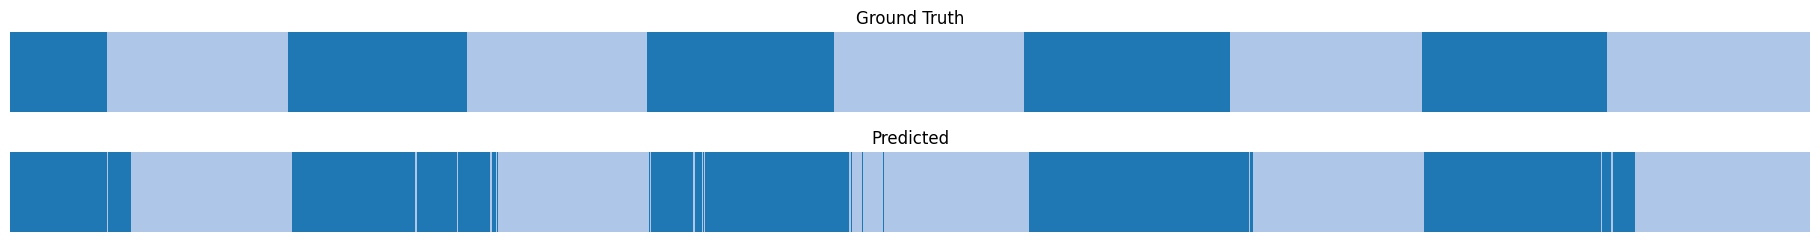

In [27]:
import matplotlib.pyplot as plt # visual from MS-TCN and diffact https://github.com/Finspire13/DiffAct/blob/main/utils.py
def plot_barcode(class_num, gt=None, pred=None, show=True, save_file=None):

    if class_num <= 10:
        color_map = plt.cm.tab10
    elif class_num > 20:
        color_map = plt.cm.gist_ncar
    else:
        color_map = plt.cm.tab20

    axprops = dict(xticks=[], yticks=[], frameon=False)
    barprops = dict(aspect='auto', cmap=color_map, 
                interpolation='nearest', vmin=0, vmax=class_num-1)

    fig = plt.figure(figsize=(18, 4))

    # a horizontal barcode
    if gt is not None:
        ax1 = fig.add_axes([0, 0.45, 1, 0.2], **axprops)
        ax1.set_title('Ground Truth')
        ax1.imshow(gt.reshape((1, -1)), **barprops)

    if pred is not None:
        ax2 = fig.add_axes([0, 0.15, 1, 0.2], **axprops)
        ax2.set_title('Predicted')
        ax2.imshow(pred.reshape((1, -1)), **barprops)

    if save_file is not None:
        fig.savefig(save_file, dpi=400)
    if show:
        plt.show()
    plt.close()

# Example data
gt_data = np.array([0, 1, 1, 2, 2, 3, 3, 3])  # Ground truth segmentation
pred_data = np.array([0, 1, 1, 1, 2, 2, 3, 3])  # Predicted segmentation

gts = sv2_merged["label"]
predictions = sv2_merged["contact_label_pred"]



transformation_dict = {"Portable Object Contact": "green", "Portable Object": "green", "Stationary Object Contact": "red", "No Contact": "yellow", "Self Contact": "red"}
# Calling the function
plot_barcode(class_num=20,
             gt=gts.map({"not_holding": 0, "holding": 1}).to_numpy().astype(np.int8),
             pred=predictions.map({"Portable Object": 1, "No Contact": 0 , "Stationary Object Contact": 0}).to_numpy().astype(np.int8),
             show=True,
             save_file=None)


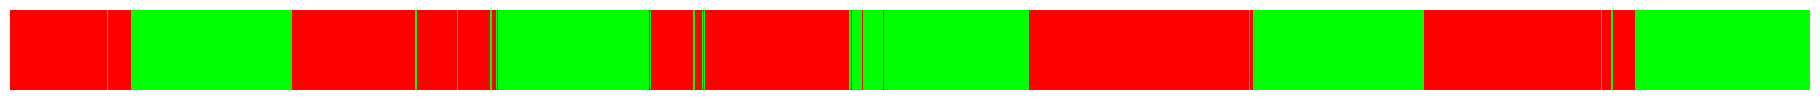

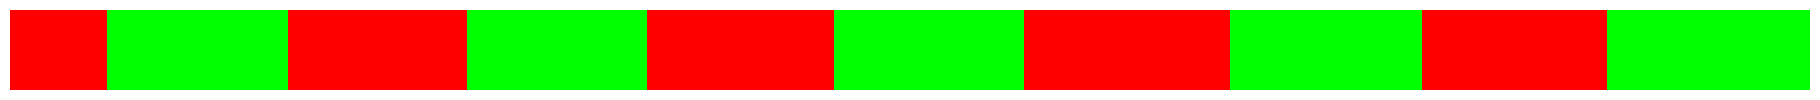

In [59]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors
def plot_barcode(gt=None, pred=None, show=True, save_file=None):
    red = np.array([1, 0, 0, 1])
    green = np.array([0, 1, 0, 1])
    colors = [red, green]
    color_map = LinearSegmentedColormap.from_list("Custom", colors, N=2)
    # color_map = matplotlib.colors.ListedColormap(['red', 'green'])

    axprops = dict(xticks=[], yticks=[], frameon=False)
    barprops = dict(aspect='auto', cmap=color_map, 
                interpolation='nearest', vmin=0, vmax=1)

    fig = plt.figure(figsize=(18, 4))

    # a horizontal barcode
    if gt is not None:
        ax1 = fig.add_axes([0, 0.45, 1, 0.2], **axprops)
        ax1.set_title('Ground Truth')
        ax1.imshow(gt.reshape((1, -1)), **barprops)

    if pred is not None:
        ax2 = fig.add_axes([0, 0.15, 1, 0.2], **axprops)
        # ax2.set_title('Predicted')
        ax2.imshow(pred.reshape((1, -1)), **barprops)

    if save_file is not None:
        fig.savefig(save_file, dpi=400)
    if show:
        plt.show()
    plt.close()

plot_barcode(
             gt=None,
             pred=predictions.map({"Portable Object": 1, "Self Contact": 0, "No Contact": 0 , "Stationary Object Contact": 0}).to_numpy().astype(bool),
             show=True,
             save_file="sv2_pred.png")

plot_barcode(
             gt=None,
             pred=gts.map({"not_holding": 0, "holding": 1}).to_numpy().astype(np.int8),
             show=True,
             save_file="sv2_gt.png")


In [51]:
predictions.map({"Portable Object": 1, "Self Contact": 0, "No Contact": 0 , "Stationary Object Contact": 0}).to_numpy().astype(bool)

array([False, False, False, ...,  True,  True,  True])